In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    validation_split=0.2
                                    )

training_set = train_datagen.flow_from_directory(
                                                 '../input/wild-eyes-dataset/EyeDataset',
                                                 target_size = (64,256),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 shuffle = True,
                                                 class_mode = 'binary',
                                                 subset="training"
                                                 )

test_set = train_datagen.flow_from_directory(
                                                 '../input/wild-eyes-dataset/EyeDataset',
                                                 target_size = (64,256),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 shuffle = True,
                                                 class_mode = 'binary',
                                                 subset="validation"
                                                 )


Found 4704 images belonging to 2 classes.
Found 1176 images belonging to 2 classes.


In [3]:
# Neural network architecture

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(64,256,1)))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 254, 16)       160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 254, 16)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 254, 16)       64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 252, 32)       4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 252, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 252, 32)       128       
_________________________________________________________________
dropout (Dropout)            (None, 60, 252, 32)       0

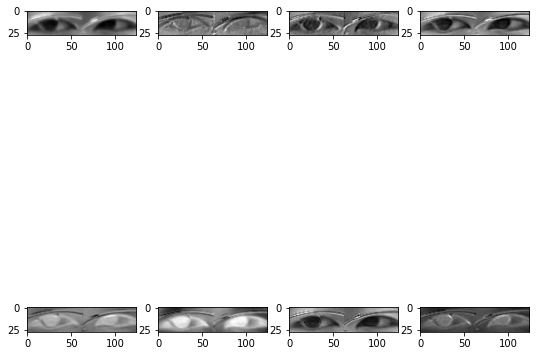

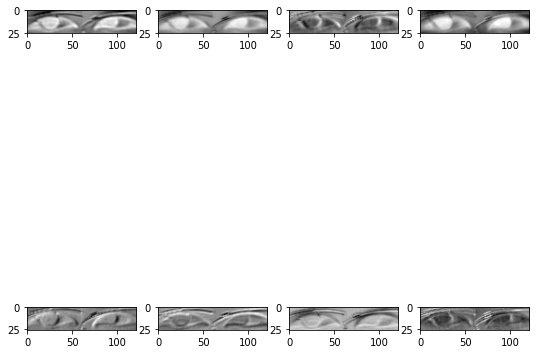

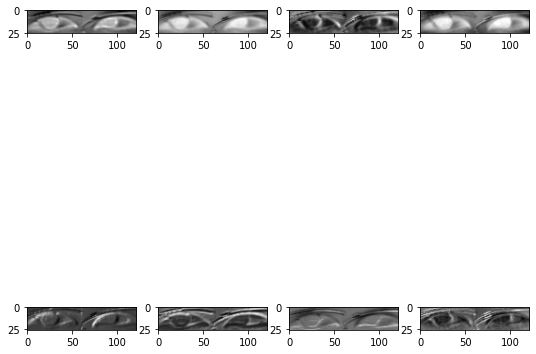

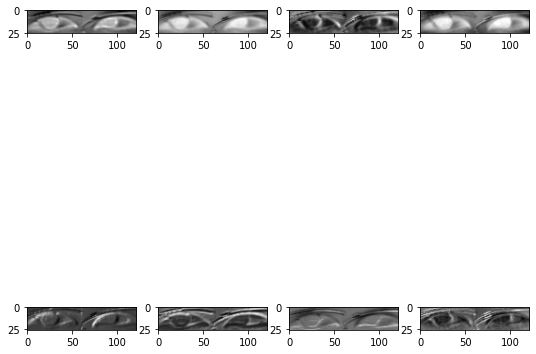

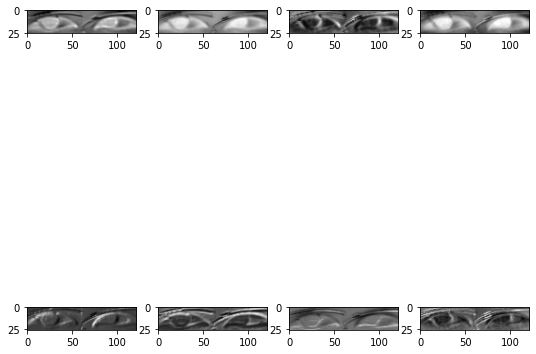

In [4]:
# Visualize feature-learning layers

X_train, y_train = next(training_set)

from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[1].reshape(1,64,256,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*4.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
col_size = 4
row_size = 2
n_layers = 15
for layer_index in range(10, n_layers):
    display_activation(activations, col_size, row_size, layer_index)


In [5]:
callback = EarlyStopping(
    monitor = "val_loss",
    patience = 4,
    restore_best_weights = True
)

In [6]:
# Training phase
history = model.fit(
                     training_set,
                     epochs = 20,
                     validation_data = test_set,
                     shuffle = True,
                     callbacks=[callback]
                    )

Epoch 1/20
74/74 [==============================] - 22s 267ms/step - loss: 0.9724 - accuracy: 0.8004 - val_loss: 9.6859 - val_accuracy: 0.1437
Epoch 2/20
74/74 [==============================] - 8s 113ms/step - loss: 0.5116 - accuracy: 0.8429 - val_loss: 0.5602 - val_accuracy: 0.7185
Epoch 3/20
74/74 [==============================] - 8s 111ms/step - loss: 0.4675 - accuracy: 0.8506 - val_loss: 1.2040 - val_accuracy: 0.8571
Epoch 4/20
74/74 [==============================] - 8s 110ms/step - loss: 0.4312 - accuracy: 0.8542 - val_loss: 1.0790 - val_accuracy: 0.8571
Epoch 5/20
74/74 [==============================] - 8s 113ms/step - loss: 0.4138 - accuracy: 0.8559 - val_loss: 0.5613 - val_accuracy: 0.8571
Epoch 6/20
74/74 [==============================] - 8s 112ms/step - loss: 0.3921 - accuracy: 0.8569 - val_loss: 0.4665 - val_accuracy: 0.8571
Epoch 7/20
74/74 [==============================] - 8s 110ms/step - loss: 0.3897 - accuracy: 0.8574 - val_loss: 0.5626 - val_accuracy: 0.8036
Epoch

In [7]:
# Evaluate Model
scoreSeg = model.evaluate_generator(test_set, verbose=1)

19/19 [==============================] - 2s 79ms/step - loss: 0.4171 - accuracy: 0.8571


In [8]:
# model.save("Eye Gaze Detector.h5")

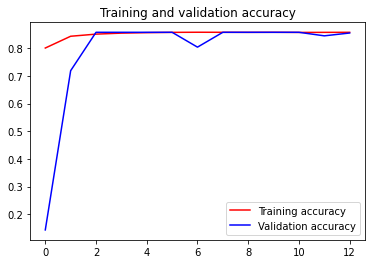

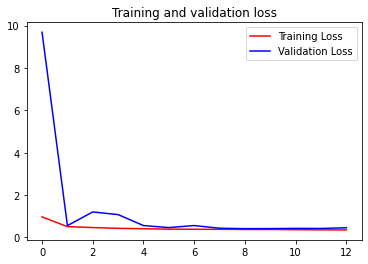

In [9]:
# Visualize Loss & Accuracy

%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()